In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

In [45]:
def f(x):
    return x * np.sin(x)

X = np.atleast_2d(np.random.uniform(0, 10.0, size=1000)).T
X = X.astype(np.float32)

y = f(X).ravel()
y += 0.5 * np.random.randn(len(y))
y = y.astype(np.float32)

xx = np.atleast_2d(np.linspace(-5, 15, 1000)).T
xx = xx.astype(np.float32)

In [46]:
def plot(y_pred, y_upper, y_lower):
    fig = plt.figure()
    plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
    plt.plot(X, y, 'g.', markersize=5, label=u'Observations', alpha=0.5)
    plt.plot(xx, y_pred, 'r-', label=u'Prediction')
    plt.plot(xx, y_upper, 'b-')
    plt.plot(xx, y_lower, 'b-')
    plt.fill(np.concatenate([xx, xx[::-1]]),
             np.concatenate([y_upper, y_lower[::-1]]),
             alpha=.1, fc='b', ec='None')
    plt.ylim(-10, 10)
    plt.show()

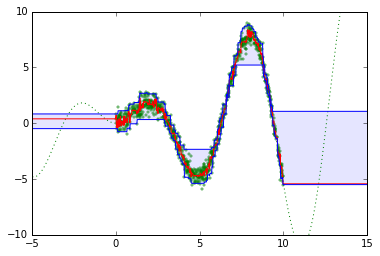

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

alpha = 0.025
r = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                              n_estimators=250, max_leaf_nodes=10)

r.set_params(alpha=alpha)
r.fit(X, y)
y_upper = r.predict(xx)

r.set_params(alpha=1.0 - alpha)
r.fit(X, y)
y_lower = r.predict(xx)

r.set_params(loss='ls')
r.fit(X, y)
y_pred = r.predict(xx)

plot(y_pred, y_upper, y_lower)

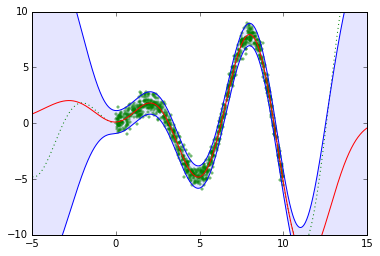

In [48]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

r = GaussianProcessRegressor(kernel=1.0 * RBF() + WhiteKernel(), alpha=0.0)
r.fit(X, y)
y_pred, std = r.predict(xx, return_std=True)

plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

In [49]:
std

array([ 8.22786676,  8.21955921,  8.21102238,  8.20225161,  8.19324241,
        8.18399025,  8.17449061,  8.16473895,  8.15473044,  8.14446103,
        8.13392588,  8.12312041,  8.11204002,  8.10068012,  8.08903612,
        8.07710343,  8.06487715,  8.05235335,  8.03952714,  8.026394  ,
        8.01294905,  7.99918848,  7.98510747,  7.97070157,  7.95596637,
        7.9408971 ,  7.92549018,  7.90974093,  7.8936451 ,  7.87719848,
        7.86039691,  7.84323628,  7.82571256,  7.80782131,  7.78955976,
        7.7709229 ,  7.75190767,  7.73251015,  7.71272671,  7.69255356,
        7.67198779,  7.65102577,  7.62966398,  7.60789981,  7.58572992,
        7.56315137,  7.54016101,  7.51675672,  7.49293557,  7.46869508,
        7.44403257,  7.41894608,  7.39343385,  7.36749357,  7.34112339,
        7.31432128,  7.28708635,  7.25941686,  7.23131153,  7.2027689 ,
        7.17378873,  7.14436986,  7.11451128,  7.08421328,  7.05347518,
        7.02229683,  6.99067787,  6.95861933,  6.92612118,  6.89

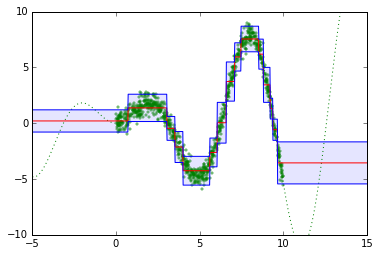

In [50]:
from skopt.learning import DecisionTreeRegressor

r = DecisionTreeRegressor(max_leaf_nodes=15)
r.fit(X, y)
y_pred, std = r.predict(xx, return_std=True)

plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

In [51]:
# Variance = variance of all training samples belonging to the same nodes

from sklearn.ensemble.forest import _generate_sample_indices

def weighted_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)  
    return variance ** 0.5


def std_v1(forest, X_train, y_train, X_test):
    # Map tree_id, node_id to list of training samples
    mapping = {}
    
    for t, tree in enumerate(forest.estimators_):
        if forest.bootstrap:
            indices = _generate_sample_indices(tree.random_state, len(X_train))
        else:
            indices = np.arange(len(X_train)).astype(int)
            
        for i, node in zip(indices, tree.apply(X_train[indices])):
            if t not in mapping:
                mapping[t] = {}
                
            if node not in mapping[t]:
                mapping[t][node] = []
                
            mapping[t][node].append(i)
   
    # Gather training samples
    std = np.zeros(len(X_test))
    
    for i, leaves in enumerate(forest.apply(X_test)):
        neighborhood = []
        weights = []
        
        for t, node in enumerate(leaves):
            neighborhood.extend(mapping[t][node])
            weights.extend([1. / len(mapping[t][node])] * len(mapping[t][node]))
            
        std[i] = weighted_std([y_train[j] for j in neighborhood], weights)
        
    return std

In [52]:
# Variance = SMAC 4.3.2 of http://arxiv.org/abs/1211.0906

def std_v2(forest, X_train, y_train, X_test):         
    std = np.zeros(len(X_test))
    mu = forest.predict(X_test)

    for t, tree in enumerate(forest.estimators_):
        var_b = tree.tree_.impurity[tree.apply(X_test)] 
        mu_b = tree.predict(X_test)
        std += var_b + mu_b ** 2
        
    std /= len(forest.estimators_)
    std -= mu ** 2
    
    return std ** 0.5

In [53]:
# Variance = variance of tree predictions

def std_v3(forest, X_test):    
    p = [tree.predict(X_test) for tree in forest.estimators_]
    std = np.std(p, axis=0)
    return std

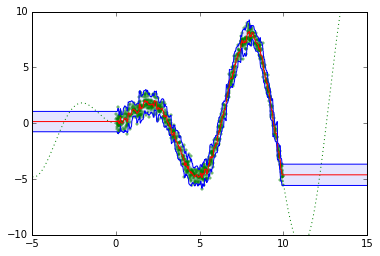

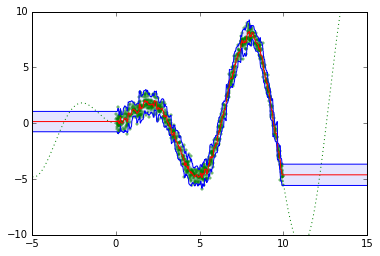

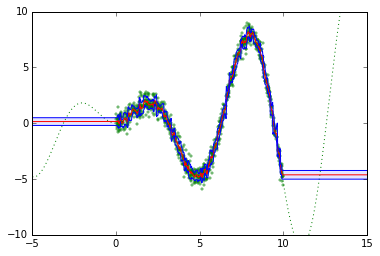

In [54]:
from sklearn.ensemble import RandomForestRegressor

r = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, random_state=1)
r.fit(X, y)

y_pred = r.predict(xx)
std = std_v1(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v2(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v3(r, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

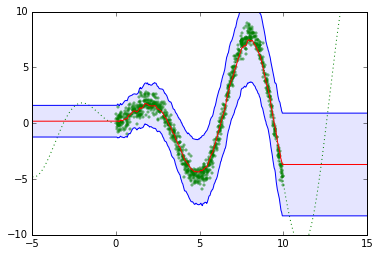

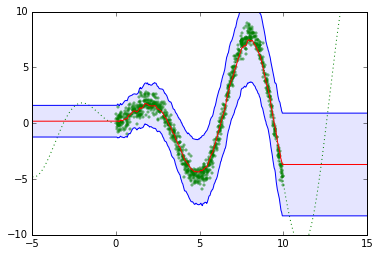

In [55]:
from sklearn.ensemble import ExtraTreesRegressor

r = ExtraTreesRegressor(n_estimators=1000, min_samples_leaf=5, random_state=1)
r.fit(X, y)

y_pred = r.predict(xx)
std = std_v1(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

y_pred = r.predict(xx)
std = std_v2(r, X, y, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

In [56]:
std

array([ 0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72266265,
        0.72266265,  0.72266265,  0.72266265,  0.72266265,  0.72

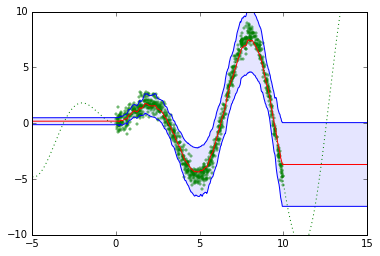

In [57]:
y_pred = r.predict(xx)
std = std_v3(r, xx)
plot(y_pred, y_pred+1.96*std, y_pred-1.96*std)

# Why is `std_v2` a good idea?

Let $\theta$ be a random variable whose values correspond to random trees $\theta_1, \dots, \theta_T$ (where the randomness here accounts for both the randomness in the data and in the construction algorithm). We want to evaluate $\mathbb{V}_{\theta, Y} [Y|\theta,X=x]$. From the law of total variance we have:

\begin{align}
\mathbb{V}_{\theta, Y} [Y|\theta,X=x] &= \mathbb{E}_{\theta} [ \mathbb{V}_{Y|\theta} [Y|\theta,X=x ] ] + \mathbb{V}_{\theta} [ \mathbb{E}_{Y|\theta} [Y|\theta,X=x ] ] \\
& = \mathbb{E}_{\theta} [ \mathbb{V}_{Y|\theta} [Y|\theta,X=x ] ] + ( \mathbb{E}_\theta [ \mathbb{E}_{Y|\theta} [Y|\theta,X=x]^2 ] - E_\theta [ \mathbb{E}_{Y|\theta} [Y|\theta,X=x]] ^ 2 )
\end{align}

If we approximate $\mathbb{E}_{Y|\theta} [Y|\theta,X=x]$ and $\mathbb{V}_{Y|\theta} [Y|\theta,X=x]$ with the empirical mean $\mu_\theta(X=x)$ and the empirical variance $\sigma^2_\theta(X=x)$ of the training samples reaching the same leaf as `X=x` in tree $\theta$, then it comes:

\begin{align}
\mathbb{V}_{\theta, Y} [Y|\theta,X=x] &\approx \mathbb{E}_{\theta} [ \sigma^2_\theta(X=x) ] +  \mathbb{E}_\theta [ \mu_\theta(X=x)^2 ] - E_\theta [ \mu_\theta(X=x) ] ^ 2 \\
&\approx \frac{1}{T} \sum_{t=1}^T ( \sigma^2_{\theta_t}(X=x) + \mu^2_{\theta_t}(X=x) ) - (\frac{1}{T} \sum_{t=1}^T ( \mu_{\theta_t}(X=x))^2 \\
&= \frac{1}{T} \sum_{t=1}^T ( \sigma^2_{\theta_t}(X=x) + \mu^2_{\theta_t}(X=x) ) - \mu(X=x)^2
\end{align}

where $\mu(X=x) = \frac{1}{T} \sum_{t=1}^T ( \mu_{\theta_t}(X=x) )$ is the prediction of the forest at $X=x$.